In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

In [2]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [3]:
train_problem = dataset[11]
test_problem = dataset[1]
train_problem["name"], test_problem["name"]

('5,20,10-3', '5,10,10-2')

In [4]:
train_gamma = np.load('solutions/gamma_11.npy')
train_delta = np.load('solutions/delta_11.npy')

In [5]:
test_gamma = np.load('solutions/gamma_1.npy')
test_delta = np.load('solutions/delta_1.npy')

In [6]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [11]:
train_graph = dglgraph(train_problem, train_gamma, train_delta)
train_target = train_graph.edata["target"][os_type]
delta_train_target = train_graph.edata["delta_target"][ss_type]
train_graph.edata["feat"][os_type][:, 0] /= 10
train_graph.edata["feat"][ss_type] /= 100

test_graph = dglgraph(test_problem, test_gamma, test_delta)
test_target = test_graph.edata["target"][os_type]
delta_test_target = test_graph.edata["delta_target"][ss_type]
test_graph.edata["feat"][os_type][:, 0] /= 10
test_graph.edata["feat"][ss_type] /= 100

train_graph = dglgraph_fixed(train_graph)
test_graph = dglgraph_fixed(test_graph)

In [20]:
model = GNN(train_graph, 15, 1)
loss2 = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

optim = Adam(model.parameters(), lr=0.005)
for i in trange(500):
    logits, delta_logits = model(train_graph)
    loss = F.binary_cross_entropy_with_logits(logits, train_target)
    serv = loss2(delta_logits[mask_train], delta_train_target[mask_train])
    loss = loss + serv
    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 10 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma, pred_delta = model.predict(train_graph, train_problem)
            train_objvalue.append(
                objvalue(train_problem, pred_gamma, pred_delta)
            )
            logits, delta_logits = model(test_graph)
            loss = F.binary_cross_entropy_with_logits(logits, test_target)
            serv = loss2(delta_logits[mask_test], delta_test_target[mask_test])
            loss = loss + serv
            test_loss.append(loss.item())
            pred_gamma, pred_delta = model.predict(test_graph, test_problem)
            test_objvalue.append(
                objvalue(test_problem, pred_gamma, pred_delta)
            )


20
22


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/fomindmitry/Documents/Github/gnn-cloud-manufacturing/cloudmanufacturing/graphconv.py:199: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  serv = np.argmax(F.softmax(delta_logits[idx]))


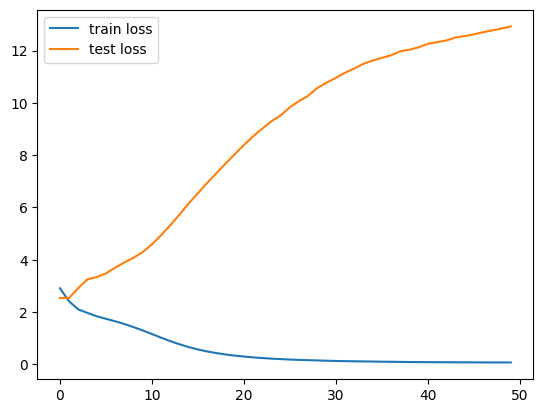

In [21]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

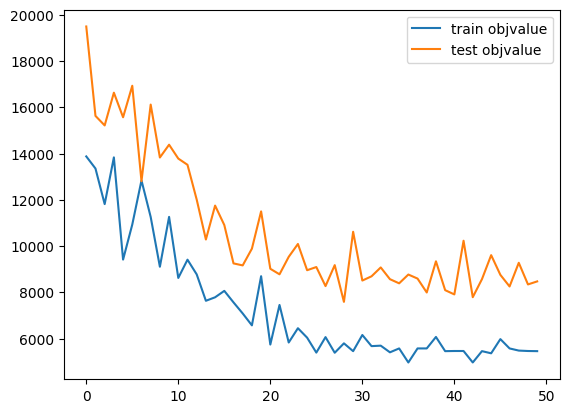

In [ ]:
plt.plot(train_objvalue, label="train objvalue")
plt.plot(test_objvalue, label="test objvalue")
plt.legend()
plt.show()

In [ ]:
min(test_objvalue)

7587.335593540179

In [ ]:
min(train_objvalue)

4965.5605540944325